In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
cov=np.array([[1,0],[0,1]])

In [3]:
mean=np.array([4,8])
dist=np.random.multivariate_normal(mean,cov,10000)
dist.shape

(10000, 2)

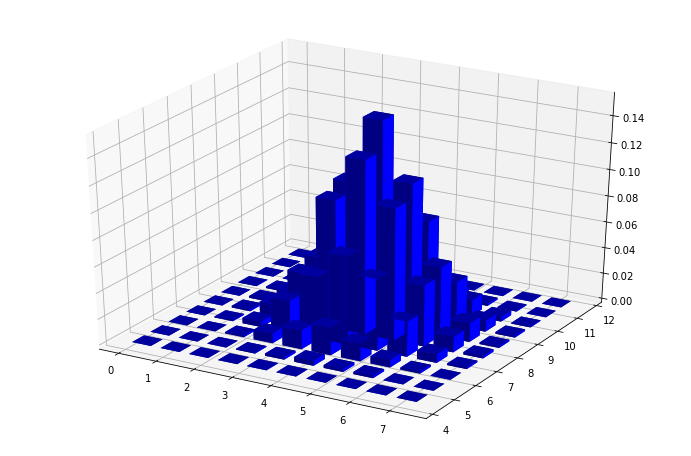

In [4]:
#the distribution we want to model with GAN

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
x=dist[:,0]
y=dist[:,1]
hist, xedges, yedges = np.histogram2d(x, y, normed=True)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)


dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

plt.show()

In [5]:
#defining discriminator and generator

from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer

#generator
input_gen=T.matrix('noise')
gen=InputLayer((None,2),input_gen)
gen=DenseLayer(gen,64,nonlinearity=lasagne.nonlinearities.rectify)
gen=DenseLayer(gen,32,nonlinearity=lasagne.nonlinearities.tanh)
gen=DenseLayer(gen,16,nonlinearity=lasagne.nonlinearities.rectify)
gen=DenseLayer(gen,2,nonlinearity=lasagne.nonlinearities.linear)

output_gen=lasagne.layers.get_output(gen)

# discriminators
D1_input = T.matrix('D1x')
D1_l1 = InputLayer((None, 2), D1_input)
D1_l2 = DenseLayer(D1_l1, 64, nonlinearity=lasagne.nonlinearities.rectify)
D1_l3 = DenseLayer(D1_l2, 16, nonlinearity=lasagne.nonlinearities.tanh)
D1_l4 = DenseLayer(D1_l3, 1, nonlinearity=lasagne.nonlinearities.sigmoid)
D1 = D1_l4

D2_l1 = InputLayer((None, 2), output_gen)
D2_l2 = DenseLayer(D2_l1, 64, nonlinearity=lasagne.nonlinearities.rectify, W=D1_l2.W, b=D1_l2.b)
D2_l3 = DenseLayer(D2_l2, 16, nonlinearity=lasagne.nonlinearities.tanh, W=D1_l3.W, b=D1_l3.b)
D2_l4 = DenseLayer(D2_l3, 1, nonlinearity=lasagne.nonlinearities.sigmoid, W=D1_l4.W, b=D1_l4.b)
D2 = D2_l4

D1_out = lasagne.layers.get_output(D1)
D2_out = lasagne.layers.get_output(D2)

In [6]:
#generator loss
G_loss = (T.log(D2_out)).mean()

#discriminator loss
D_loss = (T.log(D1_out) + T.log(1 - D2_out)).mean()

In [7]:
G_params = lasagne.layers.get_all_params(gen, trainable=True)
G_lr = theano.shared(np.array(0.01, dtype=theano.config.floatX))
G_updates = lasagne.updates.adadelta(1 - G_loss, G_params, learning_rate=1)
G_train = theano.function([input_gen], G_loss, updates=G_updates)


In [8]:
D_params = lasagne.layers.get_all_params(D1, trainable=True)
D_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
D_updates = lasagne.updates.adadelta(1 - D_loss, D_params, learning_rate=1)
D_train = theano.function([input_gen, D1_input], D_loss, updates=D_updates)

In [9]:
def sample_noise(M):
    z = np.random.uniform(size = M)
    return z

generate_dist = theano.function([input_gen],output_gen)

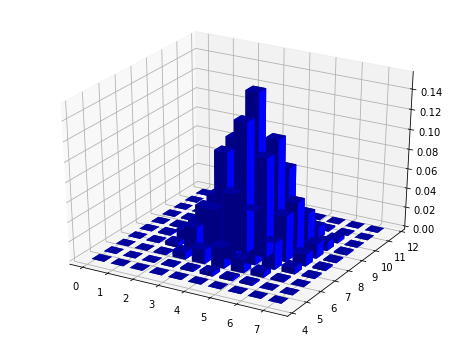

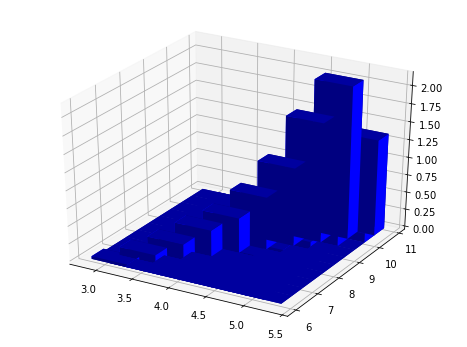

KeyboardInterrupt: 

In [10]:
from IPython import display
epochs = 100
k = 20
M = 50  # mini-batch size

for i in range(epochs):
    for j in range(20):
        x = np.float32(dist)
        z = sample_noise(2*10000)
        D_train(z.reshape(10000, 2), x)
    
    z = sample_noise(2*10000)
    G_train(z.reshape(10000, 2))
    
    if i % 10 == 0:  # lr decay
        G_lr *= 0.999
        D_lr *= 0.999


    z = sample_noise(20000)
    gen_data=generate_dist(z.reshape(10000,2))
    
    display.clear_output(wait=True)
    fig = plt.figure(figsize=(8, 6))
    
    ax = fig.add_subplot(111, projection='3d')
    x=dist[:,0]
    y=dist[:,1]
    hist, xedges, yedges = np.histogram2d(x, y, normed=True)

    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)


    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()
    dz = hist.flatten()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
    plt.show()
    
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    x=gen_data[:,0]
    y=gen_data[:,1]
    hist, xedges, yedges = np.histogram2d(x, y, normed=True)

    xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)


    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()
    dz = hist.flatten()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

    plt.show()
    

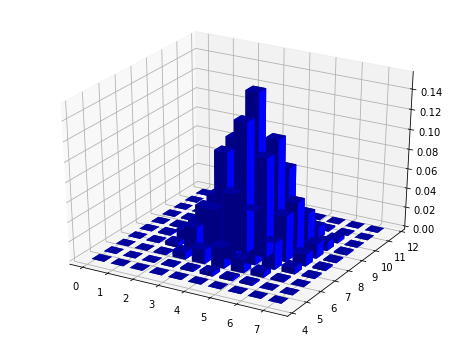

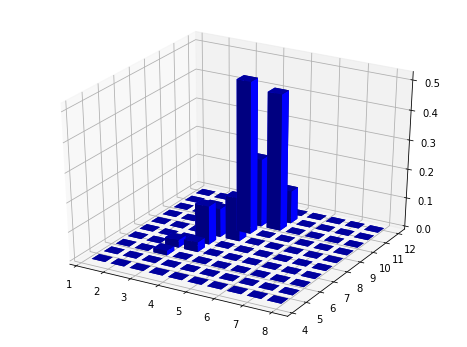

In [11]:
#while the scales of the graphs are not the same, it is clear that the generator captures the distribution of the
#data, because the generated data is in the same range as the original

fig = plt.figure(figsize=(8, 6))
    
ax = fig.add_subplot(111, projection='3d')
x=dist[:,0]
y=dist[:,1]
hist, xedges, yedges = np.histogram2d(x, y, normed=True)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)


dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
plt.show()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
x=gen_data[:,0]
y=gen_data[:,1]
hist, xedges, yedges = np.histogram2d(x, y, normed=True, range=[[1,8],[4,12]])

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)


dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

plt.show()